In [1]:
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
!pip install mglearn
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler
%matplotlib inline
from sklearn.model_selection import train_test_split

文字列として表現されているデータのタイプ
---
文字列として表現されるすべての特徴量をテキストデータとして扱うのは適切ではない場合がある。
文字列データには次の種類がある。
- 1.カテゴリデータ
- 2.意味的にはカテゴリに分類できる自由に書かれた文字列
- 3.構造化された文字列
- 4.テキストデータ

### カテゴリデータ
- 固定されたリストから得られるデータ
- 例えば色をドロップダウンメニューから選択させた結果など
- カテゴリ変数としてエンコードして使う

### 意味的にはカテゴリに分類できる自由に書かれた文字列
- カテゴリ変数としてエンコードするのがよい
- 回答に頻出する値をカテゴリ値として選ぶか、アプリケーションとして意味のあるような情報を回答から導き出すようにカテゴリを定義する
- 文字列の前処理は手作業になり自動化が難しい
- 可能であればテキストでの入力は避け、カテゴリ変数として収集できるようにする

### 構造化された文字列
- 固定したカテゴリに対応しなくても、何らかの構造をもつ文字列
- 住所、地名、人名、日付、電話番号などの何らかの識別番号

### 自由なテキストデータ
- ツイート、チャットログ、ホテルのレビュー、Wikipediaの記事全体など
- テキスト解析において、データセットは「コーパス(corpus)」、一つのテキストとして表現される個々のデータポイントは文書(document)と呼ばれる

# 映画レビューのセンチメント分析
- スタンフォード大学の研究者Andrew Maasが収集したIMDb(Internet Movie Database)Webサイトの映画レビューデータセットを用いる
  - http://ai.stanford.edu/~amaas/data/sentiment/ からダウンロードしてくる

In [2]:
!rm -r data/aclImdb/train/unsup
!tree -dL 2 data/aclImdb

rm: data/aclImdb/train/unsup: No such file or directory
data/aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    └── pos

6 directories


- posフォルダには肯定的(positive)なレビュー、negフォルダには(negative)なレビューが格納されている

In [3]:
from sklearn.datasets import load_files

review_train = load_files("data/aclImdb/train/")

- scikit-leanにはラベルがサブフォルダに対応するフォルダ構造からデータを読み込みための関数「load_files」が用意されている

In [4]:
# load_filesは一連の訓練テキストと訓練ラベルを返す
text_train, y_train = review_train.data, review_train.target
print(f"type of text_train: {type(text_train)}")
print(f"lange of text_train: {len(text_train)}")
print(f"text_train[1] :\n {text_train[1]}")

type of text_train: <class 'list'>
lange of text_train: 25000
text_train[1] :
 b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decisi

- text_trainは、長さ25000のリストで個々の要素にはレビューが文字列として含まれる
- レビューにはHTMLの改行シーケンスが含まれている場合があるため、除去する

In [5]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [6]:
print("Sample per class (training): {}".format(np.bincount(y_train)))

Sample per class (training): [12500 12500]


- このデータは肯定的なクラスと否定的なクラスがバランスするように集められている

In [7]:
reviews_test = load_files("data/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target
print(f"Number of documents in test data: {len(text_test)}")
print(f"Samples par class (test) : {np.bincount(y_test)}")
text_test = [doc.replace(b"<br />", b" ") for doc in text_train]

Number of documents in test data: 25000
Samples par class (test) : [12500 12500]


### 問題設定
あるレビューに対して、レビューのテキストに基づいて「肯定的」または「否定的」のラベルを割り当てる

Bag of Wordsによるテキスト表現
---
- 最も単純で効率がよく、機械学習で広く用いられているテキストデータ表現が「BoW(bag-of-words)」
- この表現では、章立て、パラグラフ、文章、フォーマットなどの入力テキストの持つ構造のほとんどすべてが失われ、コーパスに現れた単語がテキストに現れる回数だけを数える

### BoWの表現手順
- 1.トークン分割(Tokenization)
    - 個々の文書を単語(トークン)に分割する。例えばホワイトスペースや句読点で区切る
- 2.ボキャブラリ構築(Vocabulary building)
    - すべての文書に現れる単語をボキャブラリとして集め、番号をつける(例えばアルファベット順で)  
- 3.エンコード
    - 個々の文書に対してボキャブラリの単語が現れる回数を数える

トイデータセットに対するBoW
---
- BoW表現は変換器としてCountVectorizerに実装されている

In [8]:
bards_words = ["The fool doth think he is wise,", "but the wise man knows himself to be a fool"]

- まずは2つのサンプルデータを定義する

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

- CountVectorizerをインポートしてトイデータセットに対して、fitを呼び出す

In [10]:
print(f"Vocabulary size: {len(vect.vocabulary_)}")
print(f"Vocabulary content: {vect.vocabulary_}")

Vocabulary size: 13
Vocabulary content: {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


- CountVectorizerのfitでは訓練データのトークン分割とボキャブラリの構築が行われる 
- ボキャブラリはvocabulary_で確認できる

In [11]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


- 訓練データに対するBoW表現を作るにはtransformメソッドを呼び出す
- BoW表現は、SciPyの疎行列として格納される
    - このデータ構造は非ゼロの要素しか格納しない
- この行列は2 * 3で構成されていて、2つのデータポイントに対してそれぞれ行が割り当てられ、ボキャブラリ中の単語に対してそれぞれ特徴量が割り当てられる
- 疎行列が用いられるのは、ほとんどの文書にはボキャブラリ中の単語のごく一部しか現れず、特徴量に対する要素のほとんどが0になるため

In [12]:
print(f"Dense representation of bag_of_words:\n{bag_of_words.toarray()}")

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


- toarray()を用いると密なNumPy行列を確認できる
    - ただし、これが可能なのは単語数が13しかないためで、実際のデータセットではメモリエラーになる

映画レビューのBoW
---

In [13]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train:\n{repr(X_train)}")

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


- 訓練データのBoW表現であるX_trainの行列サイズは25000 * 74849
    - ボキャブラリは、74849の単語で構成される

In [14]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th feature:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


- CountVectorizerのget_feature_nameを使うと個々の特徴量に対応するエントリのリストを確認できる
- ボキャブラリの最初の10エントリはすべて数字
    -  これらの数字はレビューのどこかで現れたので単語として抽出されている
    -  これらの数字にはほとんど意味がない
    - ただし、「007」は映画のタイトルを指している可能性もある
- 「drawback」「draught」「drawer」など非常に意味的に近いものも別の単語としてカウントされている

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")

Mean cross-validation accuracy: 0.88


- 現状のデータセットでクラス分類器を構築して、性能の定量的な指標を得ておく
- 訓練ラベルはy_train, 訓練データのBoW表現はX_trainに格納されている
- このような高次元の疎なデータに対しては、LogisticRegressionのような線形モデルが有効
- 平均交差検証のスコアは88%となり、わりと平均的

### 交差検証でパラメタチューニングを行う
- LogisticRegressionは正則化パラメタ「C」がある

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.89
Best parameters: {'C': 0.1}


- C=0.1で89%のスコアが得られた

In [17]:
X_test = vect.transform(text_test)
print(f"{grid.score(X_test, y_test):.2f}")

0.97


### 単語の抽出を改善
- CountVectorizerはトークンを正規表現で抽出する
    - デフォルトは「"\b\w\w+\b"」
    - 抽出した単語はすべて`小文字`にする
- デフォルトで使用すると数字のような情報量のない特徴量が多く得られてしまう
- これを改善するために2つ以上の文書に登場しているトークンだけを用いるようにする
    - 一つの文書にしか現れないトークンはテストセットにも現れないと思われるため役にたたない
- トークンとして採用されるために現れる単語数をmin_dfパラメータで設定することができる

In [18]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


- 5つ以上の文書に現れたものだけをトークンとすることで約1/3まで特徴量をへらすことができた

In [19]:
feature_names = vect.get_feature_names()
print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

In [20]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


- 検証精度は89%で変わっていない
- ただし、特徴量の数が減ることで処理が高速になり、不要な特徴量が減ることでモデルの理解がしやすくなる

ストップワード
---
- 役にたたない単語を取り除くもう一つの方法として、あまりに頻出するため役にたたないワードを捨てる方法がある
- 主に2つの手法があり、一つは、言語固有のストップワードリストを作っておく方法。もう一つは頻度の高い単語を捨てる方法
- scikit-learnは英語のストップワードリストを「feature_extracition.text」モジュールに用意している

In [21]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(f"Number of stop words: {len(ENGLISH_STOP_WORDS)}")
print(f"Every 10th stopword: {list(ENGLISH_STOP_WORDS)[::10]}")

Number of stop words: 318
Every 10th stopword: ['myself', 'otherwise', 'see', 'five', 'out', 'take', 'the', 'eight', 'whenever', 'somewhere', 'he', 'thereupon', 'fire', 'less', 'besides', 'everyone', 'am', 'is', 'least', 'whence', 'ltd', 'nowhere', 're', 'nine', 'too', 'ever', 'get', 'never', 'amount', 'please', 'rather', 'either']


- リスト中のストップワードを取り除いても特徴量の数がリストの長さ(ここでは318)だけ減るだけだが、性能は向上する可能性がある

In [22]:
# stop_word="english"を指定すると、組み込みのストップワードリストを用いる
# ストップワードリストに単語を追加したり、独自のものを使うこともできる
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [23]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.88


- ストップワードを使うことで性能は少し低下している

tf-idfを用いたデータスケール変換
---
- 重要でなさそうな特徴量を落とすのではなく、特徴量がどの程度情報を持っていそうかに応じて、特徴量のスケールを変換する方法がある
- 最も一般的な手法を、「tf-idf(term frequency inverse document frequency)
- 特定の文書にだけ頻繁に現れる単語に大きな重みを与え、コーパス中の多数の文書に現れる単語にはあまり重みを与えない
    - 特定の文書にだけ現れて、他の文書には現れない単語はその文書の内容をよく示しているのではないか？という発想
- scikit-learnでは「TfidfTransformer」と「TfidfVevtorizer」というクラスで実装している
    - TfidfTransformerはCountVectorizerの生成する疎行列を入力とする
    - TfidfVectorizerはテキストデータを入力として、BoW特徴量抽出とtf-idf変換を行う
    
- 単語wのtf-ifdスコアは以下になる  
$$
tfidf(w, d) = tf(log(\frac{N+1}{Nw+1}) +1 )
$$

- Nは訓練セット中の文書の数
- Nwは訓練セット中のwが現れる文書の数
- tfは対象の文書d中にwが現れる回数

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),  LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


- この場合はtf-idf変換を行っても性能は向上していないが、tf-idfを用いると性能は少し良くなる
- tf-idfによるスケール変換は、文書を区別するためのものだが、純粋に教師なしの手法である
    - このため、ここでの重要さは本来の興味対象である「肯定的なレビュー」「否定的なレビュー」のラベルには直接関係しない    

In [25]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 訓練データセットを変換
X_train = vectorizer.transform(text_train)
# それぞれの特徴量のデータセット中での最大値を見つける
max_value = X_train.max(axis=0).toarray().ravel()
sorted_byidf = max_value.argsort()
# 特徴量名を取得
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(feature_names[sorted_byidf[:20]]))
print("Features with highest tfidf:\n{}".format(feature_names[sorted_byidf[:-20]]))

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf:
['poignant' 'disagree' 'instantly' ... 'dev' 'kornbluth' 'roy']


- tf-idfが低い特徴量は多くの文書に共通して出現するか、あまり出現しないか、もしくは非常に長い文書にしか出現しないかである

In [26]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Fearures with lowest idf:\n{}".format(feature_names[sorted_by_idf[:100]]))

Fearures with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


- 文書頻度の逆数(inverse document frequency: idf)が小さい単語を見つけることもできる
- 訓練セットに対する文書頻度の逆数は「idf_」属性に格納されている
- これらのほとんどは英語のストップワードである

モデル係数の調査
---

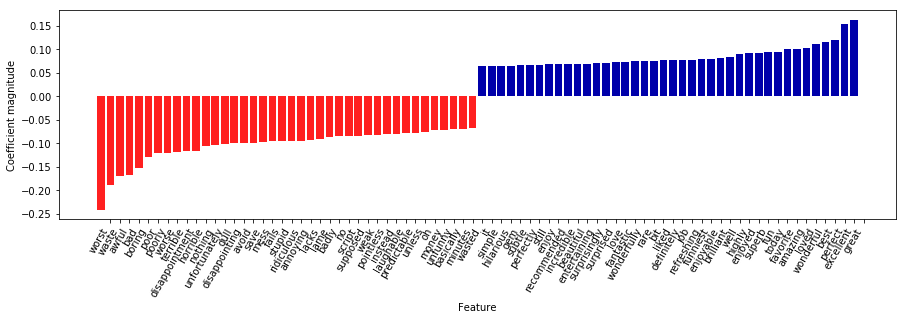

In [27]:
mglearn.tools.visualize_coefficients(
      grid.best_estimator_.named_steps["logisticregression"].coef_,
      feature_names, n_top_features=40)

- 左側の負の係数は、モデルによれば否定的なレビューを示している単語に、右側の正の係数は、モデルによれば肯定的なレビューを示している単語に対応する
- ほとんどの単語は直感的に理解できる

# 1単語よりも大きい単位のBag-of-Words(n-グラム)
- Bow表現の問題は単語の順番が完全に失われることである
    - 「it's bad, not good at all」と「it's good , not bad at all」の区別がつかない
- BoWを用いてコンテクストを捉える方法として、テキストに現れる単一のトークンだけを考えるのではなく、2つもしくは3つの連続するトークンの列を考える手法がある
- 2つのトークンを「バイグラム」、3つのトークンを「トリグラム」と呼ぶ
    - 一般的にトークンの列をn-グラムと呼ぶ
- 特徴量と考えるトークン列の長さを変更するにはCountVectorizerやTfidfVectorizerのngram_rangeパラメータを設定する
    - パラメータはタプルで特徴量とするトークン列の長さの最小長と最大長を指定する

In [28]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [29]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary : \n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary : 
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


- デフォルトでは特徴量とするトークン列の長さは最小:1 最大:1となっている(ユニグラム)

In [30]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary : \n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary : 
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


- 対象とするトークン列の長さを長くすると特徴量の数が増大し、決定的な特徴量となる

In [32]:
print("Transformed data(dense:)\n{}".format(cv.transform(bards_words).toarray()))

Transformed data(dense:)
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


- 基本的にはトークン列の最小長は1にしたほうがよい。１つの単語だけでも相当な意味をもつことがおおいため
- 5グラムぐらいまでは性能向上につながる可能性があるが、特徴量の数が爆発する上に、決定的な特徴量が増えるために過剰適合の可能性も高くなる

In [33]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary : \n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary : 
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [35]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# グリッドが比較的大きい上、トリグラムが含まれているため、このグリッドサーチは時間がかかる
pram_grid = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]
            }
grid = GridSearchCV(pipe, pram_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: \n{}".format(grid.best_params_))


Best cross-validation score: 0.91
Best parameters: 
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


- バイグラム特徴量とトリグラム特徴量を加えることで1%以上性能が向上している

In [44]:
# グリッドサーチのスコアを取り出す
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T # ヒートマップとして可視化
heatmap = mglearn.tools.heatmap(scores,
                                xlabel="C", 
                                ylabel="ngram_range",
                                cmap="viridis",
                                fmt="%.3f",
                                xticklabels=param_grid['logisticregression__C'],
                                yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

KeyError: 'tfidfvectorizer__ngram_range'

- ヒートマップから、バイグラムを追加することで性能はかなり向上するが、トリグラムを追加しても精度はわずかしか向上しないことがわかる

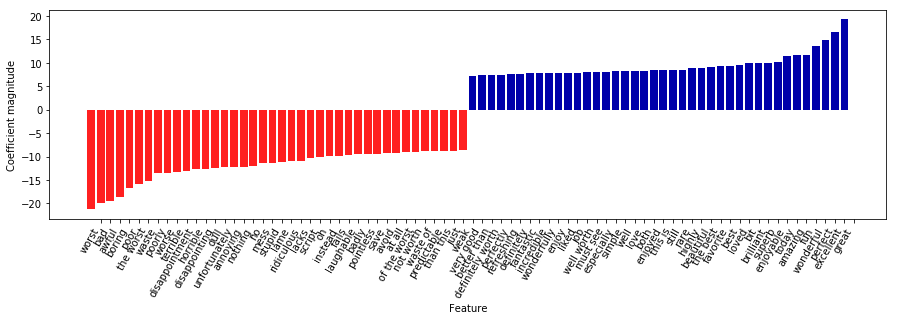

In [40]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

- tf-idfスケールを用いて、ユニグラム、バイグラム、トリグラムを用いたときの最も重要な特徴量
- 「worth」とう単語はユニグラムモデルでは出ていなかったが、「definitely worth」や「well worth」などが登場している

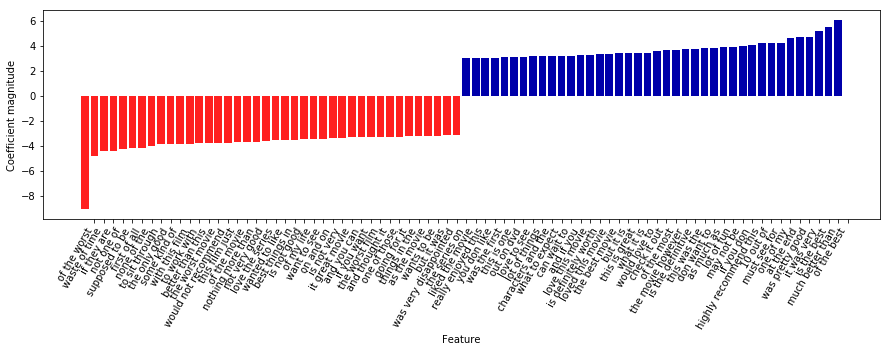

In [41]:
# トリグラムの特徴量を見つける
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# トリグラム特徴量だけを可視化
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=40)

# 語幹処理、見出し語化
- ボキャブラリに"drawback"と"drawbacks"、"drawer"と"drawers"、"drawing"のように同じ単語の単数形と複数形が含まれるケースがある
- また"replace"、"replaced"、"replacement"、"replaces"、"replacing"など動詞の変化形が含まれることもある
- 上記のような問題は個々の単語を「語幹(word stem)」として表現することで解決できる
- 単語の末尾につく特定の形を取り除くといったようなルールベースのヒューリスティックで行う場合にはこれを「語幹処理(stemming)」と呼ぶ
- 知られている単語に対して、辞書を用いて、単語の文章での役割を考慮して行う場合には「見出し語化(lemmatization)」と呼び単語の標準的な形を「見出し語(lemma)」と呼ぶ
- 語幹処理、見出し語かはいずれも単語の正規形を取り出そうとする「正規化(normalization)」である
- 語幹処理はnltkパッケージ
- 見出し語かにはspacyパッケージを用いる

In [53]:
!pip install spacy --ignore-installed --user
import spacy
import nltk

# spacyの英語モデルをロード
en_nlp = spacy.load('en')
# nltkのPorter stemmerのインスタンスを作成
stemmer = nltk.stem.PorterStemmer()

# spacyによる見出し語化とnltkによる語幹処理を比較する関数
def compare_normalization(doc):
    # spacyで文書をトークン分割
    doc_spacy = en_nlp(doc)
    # spacyで見つけた見出し語を表示
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # Porter stemmerで見つけたトークンを表示
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

  Using cached https://files.pythonhosted.org/packages/a6/0a/2defbdd9bd3a436ee0642bb8d8a66d16e523122d33384a04548dcfab23ba/numpy-1.15.1-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/65/47/7e02164a2a3db50ed6d8a6ab1d6d60b69c4c3fdf57a284257925dfc12bda/requests-2.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9e/9b/62c60d2f5bc135d2aa1d8c8a86aaf84edb719a59c7f11a4316259e61a298/plac-0.9.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/df/f7/04fee6ac349e915b82171f8e23cee63644d83663b34c539f7a09aed18f9e/certifi-2018.8.24-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bd/c9/6fdd990019071a4a32a5e7cb78a1d92c53851ef4f56f62a3486e6a7d8ffb/urllib3-1.23-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/char

ModuleNotFoundError: No module named 'spacy'

# トピックモデリングと文書クラスタリング
- トピックモデリング(topic modeling)とは、通常は教師なし学習でそれぞれの文書に対して1つ以上のトピックを割り当てるタスクをまとめて呼ぶ言葉
- 多くの場合、トピックモデリングというと「LDA(Latent Direchlet Allocation)」と呼ばれる特定の成分分析手法を指す

### LDA(Latent Dirichlet Allocation)
- 直感的に説明すると同時に現れる頻度の高い単語の集合(トピック)を探す
- 機械学習モデルのトピックは、PCAやNMFの成分に近く、解釈できる意味を持つかもしれないが、持たないかもしれない


In [55]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [57]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)
# ここではモデルの構築と変換を一度に行う
# 変換には時間がかかるが同時に行うことで時間を節約できる
document_topics = lda.fit_transform(X)

In [ ]:
lda.components_nts_.shape

- それぞれの単語のそのトピックに対する重要性を格納した`components_`属性がある

In [ ]:
#　それぞれのトピック(components_の行)に対して特徴量を昇順でソート
# ソートを降順にするために[:, ::-1]で行を反転
sorting = np.argsort(lda.components_ponents_, axis=1)[:, ::-1]
# vecorizerから特徴量名を取得
feature_names = np.array(vect.get_feature_names())

In [ ]:
# 最初の10トピックを表示
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                          sorting=sorting, topics_per_chunk=5, n_words=10)